## Lecture 4 & 5 ML Demonstration

This is a ML demonstration on Gaussian Process, Support Vector Machine, and Logistic Regression. 

#### Gaussian Process - Noiseless Case

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [2]:
np.random.seed(1)

#### Function to Predict

In [3]:
def f(x):
    return np.sin(x)

#### Observation Data X and Y

In [4]:
X = np.atleast_2d([1., 3., 5., 6., 7., 8.,9.]).T

In [5]:
y = f(X).ravel()

#### For evaluation of the real function, the prediction, and its MSE

1. Define x for evaluation
2. Initiate Kernel Trick: It can be combination of kernels from pg 37 in Lecture 4 Note.
3. Fit using GaussianPrecessRegressor (hyperparameters are adjustable, strongly encourage to look over them)
4. Make Predictions (Posterior)

In [6]:
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

#### Initiate GP: Give the kernel trick

I used the radial basis function kernel, a.k.a. RBF kernel, and the constant kernel. 

$K(x,x')=\exp\large({\frac{-|| x-x'||^2}{2\sigma^2}})$

$K(x,x')=Ck(x,x')$ where $C>0$

In [7]:
kernel = C(1.0, (1e-3, 1e3))*RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

#### Fit Data

In [8]:
gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=10), n_restarts_optimizer=20,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [9]:
y_pred, sigma = gp.predict(x, return_std=True)

In [10]:
MSE1 = np.square(np.subtract(f(x),y_pred)).mean() 
print(MSE1)

0.877024766863


In [11]:
np.mean(sigma)

0.043996923718773402

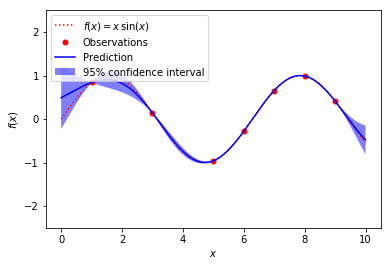

In [12]:
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred -  1.9600*sigma,
                        (y_pred +  1.9600*sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-2.5,2.5)
plt.legend(loc='upper left')

plt.show()

In [13]:
MSE1 = np.square(np.subtract(f(x),y_pred)).mean() 

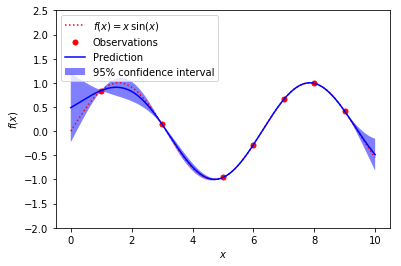

In [24]:
kernel = RBF(1, (1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X, y)
y_pred, sigma = gp.predict(x, return_std=True)
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600*sigma,
                        (y_pred +  1.9600*sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-2.0, 2.5)
plt.legend(loc='upper left')
plt.show()

In [15]:
MSE = np.square(np.subtract(f(x),y_pred)).mean() 

We have made two regressions using the combination of kernels and a single with the radial basis kernel. When we compare the two results, we find that they are not much different. It is because of the original function is simple. IF the functions get complicated, then sometimes, we may need multiple kernels be involved.

In [16]:
print(MSE1,MSE)

(0.87702476686275999, 0.87724046553830715)


Then we will do the same work but without using packages/library except the basic math tools. 

In [17]:
n = 50
Xtest = np.linspace(0, 10, n).reshape(-1,1)

In [18]:
def kernel(a, b, param):   ## Define the kernel function, this is same as RBF above. 
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 0.1
K_ss = kernel(Xtest, Xtest, param)

In [19]:
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))  ## Square root of the covariance matrix. 

In [20]:
f_prior = np.dot(L, np.random.normal(size=(n,3))) 3 ## sets of standard normals for the test points. 

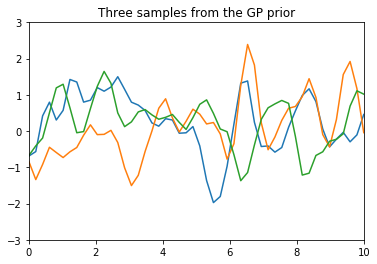

In [22]:
plt.plot(Xtest, f_prior)
plt.axis([0, 10, -3, 3])
plt.title('Three samples from the GP prior')
plt.show()

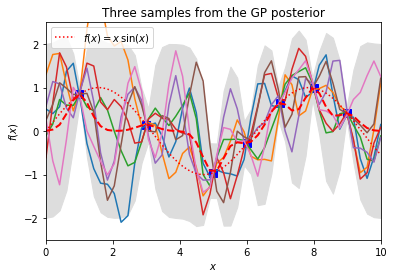

In [23]:
## No Noise Case:
Xtrain = np.array([1., 3., 5., 6., 7., 8.,9.]).reshape(7,1)
ytrain = np.sin(Xtrain)

# Apply the kernel function to our tra1ining points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)

# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,7)))

plt.plot(Xtrain, ytrain, 'bs', ms=8)
plt.plot(Xtest, f_post)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(Xtest, mu, 'r--', lw=2)
plt.axis([0, 10, -2.5,2.5 ])
plt.legend(loc='upper left')
plt.title('Three samples from the GP posterior')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

### SVM

Here, we are going to demonstrate SVM classification and compare it to Logistic Regression accuracy. 

1. We are going test SVM when we have a linearly separable case. 
2. We are going to observe that SVM provides the best decision boundary comparing to three different arbitrary chosen boundaries. 
3. Then we are going to have another binary classification test using Breast Cancer Data. 
4. We then test the logistic regression test and compare with SVM.

In [25]:
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.svm import SVC
from sklearn import datasets, svm, metrics
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [26]:
X, Y = make_blobs(n_samples=500, centers=2, 
                  random_state=0, cluster_std=0.40) 

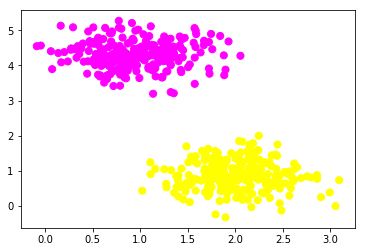

In [27]:
plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='spring'); 
plt.show()  

In [28]:
xfit = np.linspace(-1, 3.5) 

#### Make three arbitrary decision boundary that clearly separates two classes.

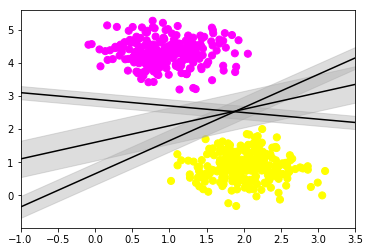

In [29]:
plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='spring') 
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]: 
    yfit = m * xfit + b 
    plt.plot(xfit, yfit, '-k') 
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',  
    color='#AAAAAA', alpha=0.4) 
  
plt.xlim(-1, 3.5); 
plt.show() 

Then use SVM classifier, SVC. Here we used kernel optioin "linear". We have different options for this. 

We will observe that SVC will provide the best decision among four boundaries including the SVC result. 

In [30]:
clf = SVC(kernel='linear') 

In [31]:
clf.fit(X, Y) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

hyperplane y(x)=0.400289927552x+1.88392285086


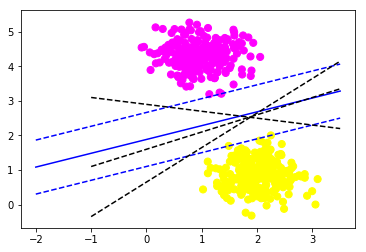

In [32]:
w = clf.coef_[0]
a = -w[0] / w[1]

xx = np.linspace(-2,3.5)
yy = a * xx - clf.intercept_[0] / w[1]
print('hyperplane y(x)='+str(a)+'x+'+str(-clf.intercept_[0] / w[1]))

plt.plot(xx, yy, '-b')
yy = a * xx - (clf.intercept_[0] - 1) / w[1]
plt.plot(xx, yy, '--b')
yy = a * xx - (clf.intercept_[0] + 1) / w[1]
plt.plot(xx, yy, '--b')

plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='spring') 
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]: 
    yfit = m * xfit + b 
    plt.plot(xfit, yfit, '--k') 
plt.show()

#### SVM & Logistic Regression: Accuracy Test w/ Multivariable Data Set

1. Load Data
2. Split Training and Test for data and target
3. Construct a model and fit with training set. 
4. Predict using the test set. 
5. Confirm the accuracy

In [33]:
cancer = datasets.load_breast_cancer()
print("Features: ", cancer.feature_names)
print("Labels: ", cancer.target_names)

('Features: ', array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'], 
      dtype='|S23'))
('Labels: ', array(['malignant', 'benign'], 
      dtype='|S9'))


In [34]:
df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
df['target'] = cancer['target']

In [35]:
df.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    test_size=0.3,random_state=109) # 70% training and 30% test

In [37]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [38]:
print("The accuracy is:"+str(metrics.accuracy_score(y_test, y_pred)*100)+'%')

The accuracy is:96.4912280702%


In [39]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 61   2]
 [  4 104]]


##### Logistic Regression

In [41]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
accuracy = logreg.score(X_test, y_test)
print('The accuracy is: ' + str(accuracy *100) + '%')

The accuracy is: 97.0760233918%


In [43]:
predictions = logreg.predict(X_test)

In [44]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predictions)
print(confusion_matrix)


[[ 61   2]
 [  3 105]]
